# TODO: Describe the purpose of this file

In [33]:
%matplotlib inline

In [34]:
import logging

import matplotlib.pyplot as plt
import numpy as np

from fedmoe_plots.plotting_utils import (
    configure_logging_for_jupyter,
    create_publication_ready_plot,
    enhance_plot_for_presentation,
    run_matplotlib_preamble,
)
from fedmoe_plots.wall_time_model import ExperimentWallTime

CUSTOM_FONTS = True  # Fixed! Now Montserrat will be preserved with LaTeX fallbacks
USE_INVERTED_STYLE = False  # Fixed! Now the style is not inverted
BACKEND = "inline"  # Use inline backend for Jupyter
DISABLE_LATEX = True  # Disable LaTeX rendering


configure_logging_for_jupyter()
color_palette, line_styles, patterns = run_matplotlib_preamble(
    custom_fonts=CUSTOM_FONTS,
    use_inverted_style=USE_INVERTED_STYLE,
    backend=BACKEND,
    disable_latex=DISABLE_LATEX,
)

log = logging.getLogger("wall_clock_time_model.ipynb")

# Figure size
fig_size = (5, 4)  # (4, 3)
fig_size1 = (5, 4)  # (8, 3)
fig_size2 = (5, 4)  # (8, 3)

In [35]:
methods_to_label = {
    "ddp": "DDP" if DISABLE_LATEX else r"\texttt{DDP}",
    "fedavg": "FedAvg" if DISABLE_LATEX else r"\texttt{FedAvg}",
    "localadam": "LocalAdam" if DISABLE_LATEX else r"\texttt{LocalAdam}",
    "desloc": "DES-LOC-Adam" if DISABLE_LATEX else r"\texttt{DES-LOC-Adam}",
}

In [36]:
experiment_135m = ExperimentWallTime(
    precision="fp16",
    dataset_size=int(40 * 10e9),  # 40 billion tokens
    n_model_parameters=int(135 * 10e6),  # 135 million parameters
    n_workers=4,  # 4 workers
    worker_flops_per_second=312 * 10e12,  # 1xH100
    worker_mfu=0.5,  # 50% MFU
    p2p_network_latency=10e-3,  # 10 ms
    equivalent_communication_steps=1,  # 100 equivalent communication steps
)
experiment_1_3b = ExperimentWallTime(
    precision="fp16",
    dataset_size=int(40 * 10e9),  # 40 billion tokens
    n_model_parameters=int(1.3 * 10e9),  # 1.3 billion parameters
    n_workers=4,  # 4 workers
    worker_flops_per_second=312 * 10e12,  # 1xH100
    worker_mfu=0.5,  # 50% MFU
    p2p_network_latency=10e-3,  # 10 ms
    equivalent_communication_steps=1,  # 100 equivalent communication steps
)
experiment_13b = ExperimentWallTime(
    precision="fp16",
    dataset_size=int(40 * 10e9),  # 40 billion tokens
    n_model_parameters=int(13 * 10e9),  # 13 billion parameters
    n_workers=4,  # 4 workers
    worker_flops_per_second=312 * 10e12,  # 1xH100
    worker_mfu=0.5,  # 50% MFU
    p2p_network_latency=10e-3,  # 10 ms
    equivalent_communication_steps=1,  # 100 equivalent communication steps
)
experiment_gaia2 = ExperimentWallTime(
    precision="fp16",
    # batch size * sequence length * number of batches
    dataset_size=(256 * 12600 * 460_000),
    n_model_parameters=int(8.4 * 10e9),  # 8.4 billion parameters
    n_workers=4,  # 4 workers
    worker_flops_per_second=312 * 10e12,  # 1xH100
    worker_mfu=0.4,  # 40% MFU
    p2p_network_latency=10e-3,  # 10 ms
    equivalent_communication_steps=1,  # 100 equivalent communication steps
)
sequential_steps = 20_000
fedavg_sync_frequency = 256
localadam_sync_frequency = 256
desync_sync_frequencies = (256, 3 * 256, 6 * 256)

In [37]:
def _get_fedavg_equivalent_communication_steps(
    sync_frequency: int,
    sequential_steps: int,
) -> int:
    return _get_desloc_equivalent_communication_steps(
        (sync_frequency,),
        sequential_steps,
    )


def _get_localadam_equivalent_communication_steps(
    sync_frequency: int,
    sequential_steps: int,
) -> int:
    return _get_desloc_equivalent_communication_steps(
        (sync_frequency, sync_frequency, sync_frequency),
        sequential_steps,
    )


def _get_desloc_equivalent_communication_steps(
    sync_frequencies: tuple[int, ...],
    sequential_steps: int,
) -> int:
    return sum(
        sequential_steps // sync_frequency for sync_frequency in sync_frequencies
    )

In [38]:
base_experiment = experiment_1_3b
experiments: dict[str, ExperimentWallTime] = {
    "fedavg": base_experiment.copy(
        equivalent_communication_steps=_get_fedavg_equivalent_communication_steps(
            fedavg_sync_frequency,
            sequential_steps,
        ),
    ),
    "localadam": base_experiment.copy(
        equivalent_communication_steps=_get_localadam_equivalent_communication_steps(
            localadam_sync_frequency,
            sequential_steps,
        ),
    ),
    "desloc": base_experiment.copy(
        equivalent_communication_steps=_get_desloc_equivalent_communication_steps(
            desync_sync_frequencies,
            sequential_steps,
        ),
    ),
    "ddp": base_experiment.copy(
        equivalent_communication_steps=sequential_steps,
    ),
}

In [39]:
bandwidths = 5 * np.logspace(4, 11, 10000, base=10)

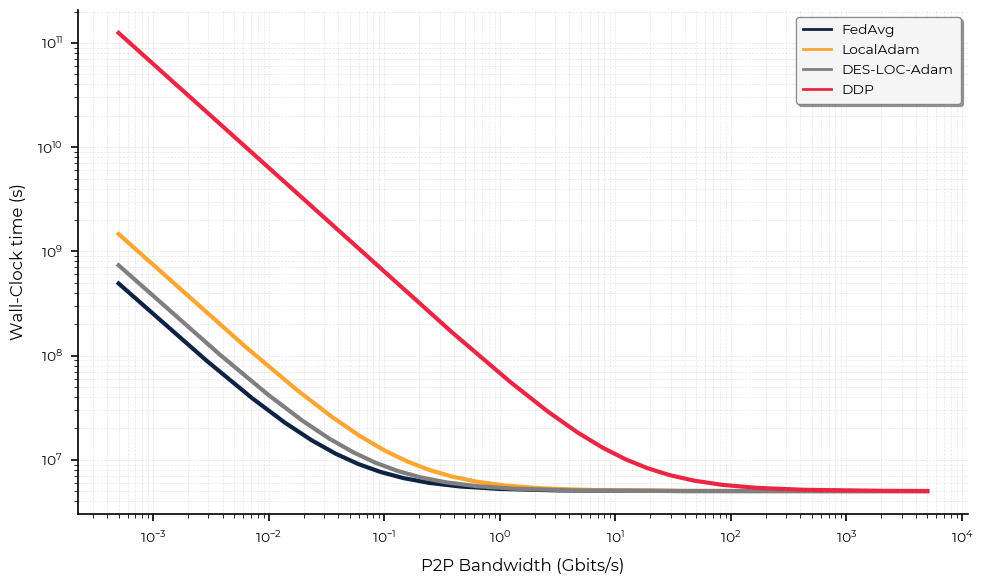

In [40]:
fig, ax = create_publication_ready_plot(figsize=(10, 6), use_improved_style=True)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("P2P Bandwidth (Gbits/s)")
ax.set_ylabel("Wall-Clock time (s)")
ax.grid(which="both", linestyle="--", linewidth=0.5)
for i, (method, experiment) in enumerate(experiments.items()):
    plt.plot(
        10e-9 * bandwidths,
        [experiment.total_time(b) for b in bandwidths],
        label=methods_to_label[method],
        color=color_palette[i],
    )
plt.legend()

# Enhance for presentation
enhance_plot_for_presentation(ax, legend_shadow=True)

plt.tight_layout()
plt.show()

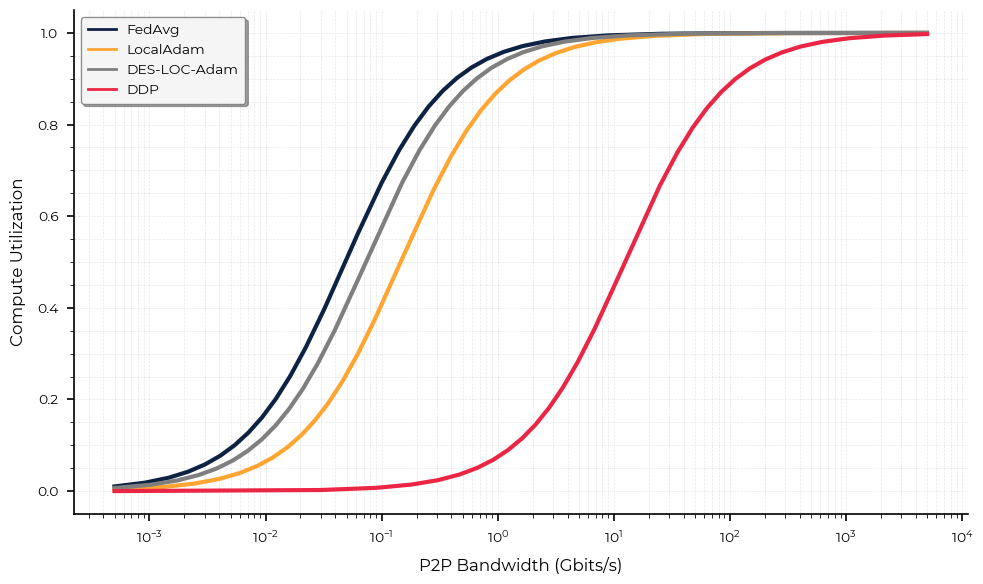

In [41]:
fig, ax = create_publication_ready_plot(figsize=(10, 6), use_improved_style=True)
ax.set_xscale("log")
ax.set_xlabel("P2P Bandwidth (Gbits/s)")
ax.set_ylabel("Compute Utilization")
ax.grid(which="both", linestyle="--", linewidth=0.5)
for i, (method, experiment) in enumerate(experiments.items()):
    compute_time = experiment.compute_time()
    plt.plot(
        10e-9 * bandwidths,
        [compute_time / experiment.total_time(b) for b in bandwidths],
        label=methods_to_label[method],
        color=color_palette[i],
    )
plt.legend()

# Enhance for presentation
enhance_plot_for_presentation(ax, legend_shadow=True)

plt.tight_layout()
plt.show()

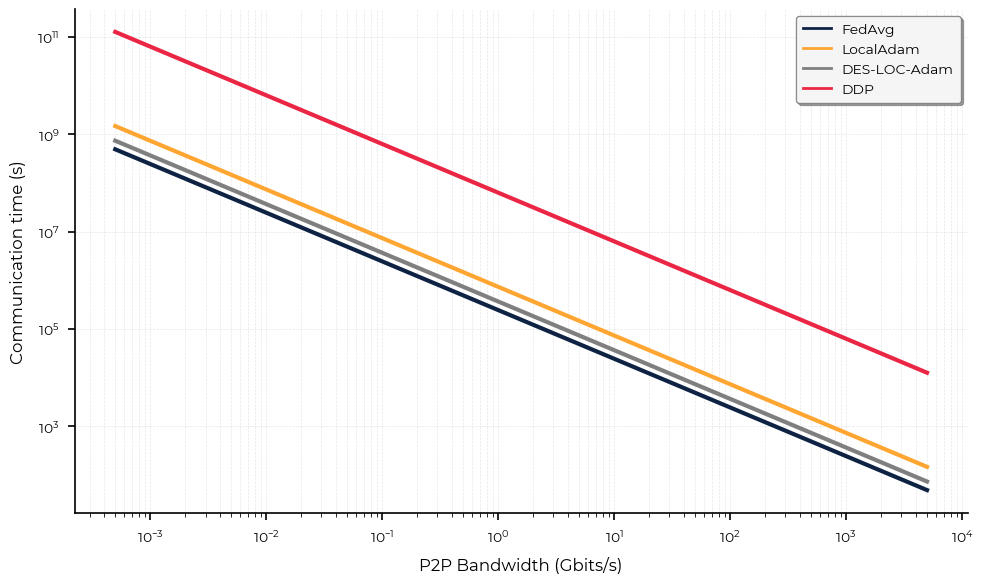

In [42]:
fig, ax = create_publication_ready_plot(figsize=(10, 6), use_improved_style=True)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("P2P Bandwidth (Gbits/s)")
ax.set_ylabel("Communication time (s)")
ax.grid(which="both", linestyle="--", linewidth=0.5)
for i, (method, experiment) in enumerate(experiments.items()):
    compute_time = experiment.compute_time()
    plt.plot(
        10e-9 * bandwidths,
        [experiment.total_time(b) - compute_time for b in bandwidths],
        label=methods_to_label[method],
        color=color_palette[i],
    )
plt.legend()

# Enhance for presentation
enhance_plot_for_presentation(ax, legend_shadow=True)

plt.tight_layout()
plt.show()

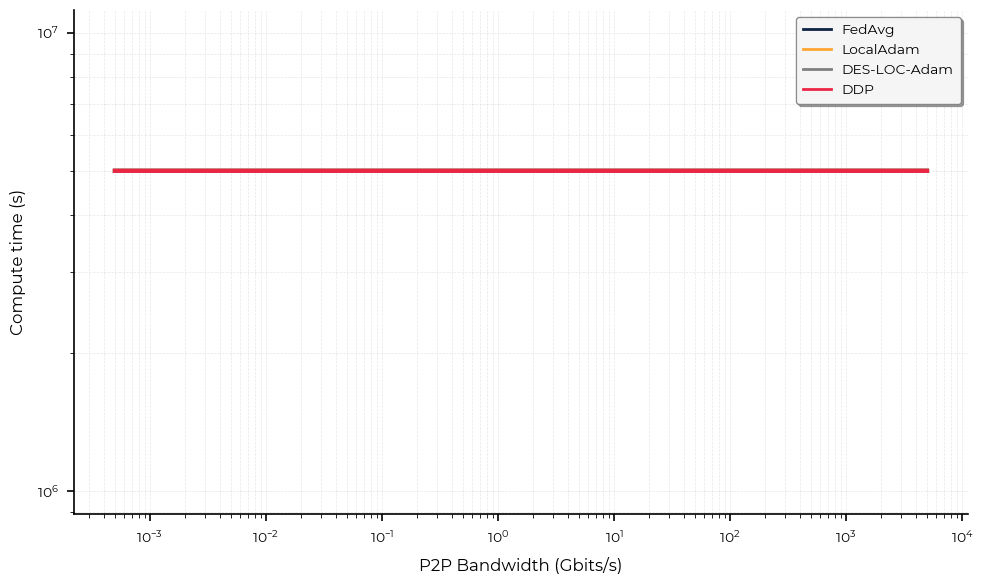

In [43]:
fig, ax = create_publication_ready_plot(figsize=(10, 6), use_improved_style=True)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("P2P Bandwidth (Gbits/s)")
ax.set_ylabel("Compute time (s)")
ax.grid(which="both", linestyle="--", linewidth=0.5)
for i, (method, experiment) in enumerate(experiments.items()):
    compute_time = experiment.compute_time()
    plt.plot(
        10e-9 * bandwidths,
        [compute_time for _b in bandwidths],
        label=methods_to_label[method],
        color=color_palette[i],
    )
plt.legend()

# Enhance for presentation
enhance_plot_for_presentation(ax, legend_shadow=True)

plt.tight_layout()
plt.show()

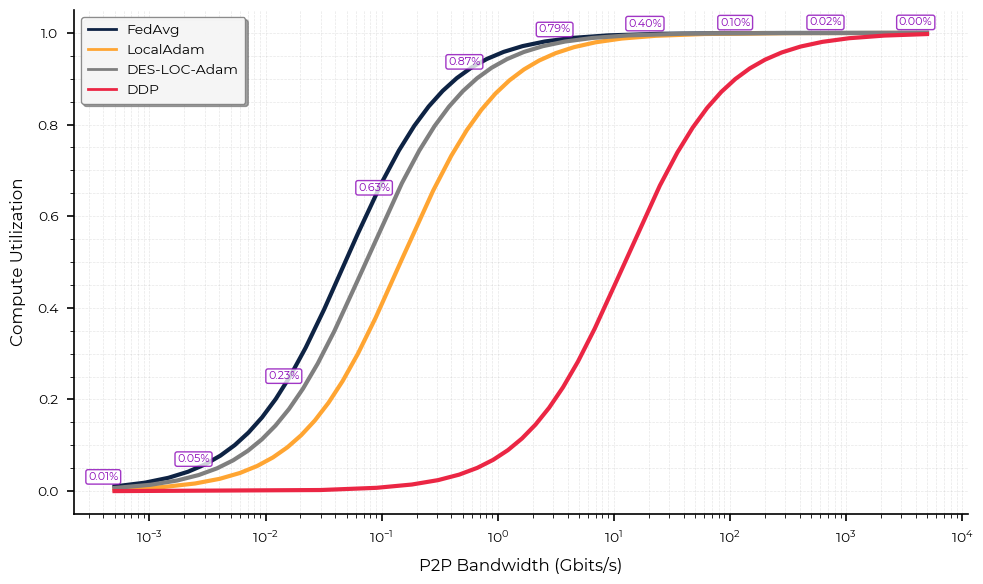

In [44]:
fig, ax = create_publication_ready_plot(figsize=(10, 6), use_improved_style=True)
ax.set_xscale("log")
ax.set_xlabel("P2P Bandwidth (Gbits/s)")
ax.set_ylabel("Compute Utilization")
ax.grid(which="both", linestyle="--", linewidth=0.5)
lines: dict[float, dict[str, float]] = {}
fewer_bandwidths = 4 * np.logspace(4, 11, 10, base=10)
offset = 0.012
for i, (method, experiment) in enumerate(experiments.items()):
    for b in fewer_bandwidths:
        x_b = 10e-9 * b
        if x_b not in lines:
            lines[x_b] = {}
        if method not in lines[x_b]:
            lines[x_b][method] = compute_time / experiment.total_time(b)
    compute_time = experiment.compute_time()
    plt.plot(
        10e-9 * bandwidths,
        [compute_time / experiment.total_time(b) for b in bandwidths],
        label=methods_to_label[method],
        color=color_palette[i],
    )
# Plot small text boxes on top of the data point with the percentual gain
for x_data, (methods_dict) in lines.items():
    # Transform sorted methods to percentages compared to the the slowest method
    min_value = min(methods_dict.values())
    deltas = {method: value - min_value for method, value in methods_dict.items()}
    # Plot the textbox only for the highest percentage
    max_delta_method = max(deltas, key=lambda x: deltas[x])
    max_delta = deltas[max_delta_method]
    plt.text(
        x_data,
        max_delta + min_value + offset,
        f"{max_delta:.2f}%",
        fontsize=8,
        ha="center",
        va="bottom",
        color=color_palette[7],
        bbox={
            "boxstyle": "round,pad=0.2",
            "facecolor": "white",
            "edgecolor": color_palette[7],
            "alpha": 0.8,
        },
    )

plt.legend()

# Enhance for presentation
enhance_plot_for_presentation(ax, legend_shadow=True)

plt.tight_layout()
plt.show()